# Tennis Project Report

In this project, I train two agents to play tennis using MADDPG algorithm.


## Problem Overview

**Environment**: In this environment, two agents control rackets to bounce a ball back and forth over a net.  The goal of each agent is to keep the ball in play.

**Observation Space**: The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation. 

**Action Space**: Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

**Reward**: If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

**Problem Sovled**: The task is episodic, and in order to solve the environment, your agents must get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents). Specifically,

    - After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores.
    
    - This yields a single **score** for each episode.

The environment is considered solved, when the average (over 100 episodes) of those **scores** is at least +0.5.


## MADDPG

MADDPG is the multi-agent version of DDPG algorithm, addressing 2 outstanding issues single-agent policy gradient method (i.e. DDPG) face:

1. multi-agent environment is non-stationary, since each agent's policy changes as training progress.

2. Policy-gradient variance grows as number of agent increase.

MADDPG address the above issues by the following key concepts

1. MADDPG adopts a framework of **centralized training** and **decentralized execution**. 

    - **Centralized training**: agents share experience during training by saving experience and drawing samples from a common experience-replay buffer

    - **decentralized execution**: each agent uses only local observation during execution.

2. Correspondingly, the actor-critic policy gradient method is modified to reflect the above idea:

    - each agent's critic network is augmented with information about the policies of other agents
    
    - actor has access to local information

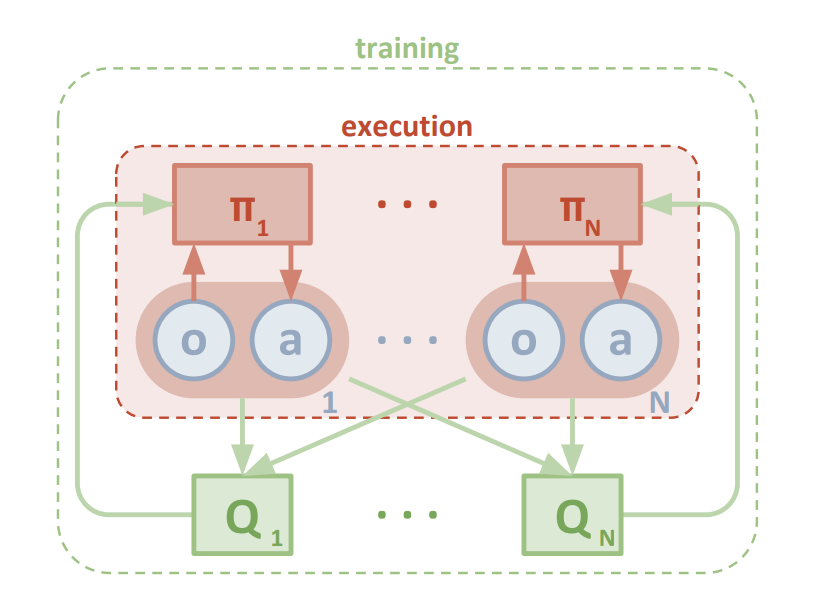
[source](https://arxiv.org/pdf/1706.02275.pdf)


Inherited from DDPG, MADDPG has the following features:
 
### 1. MADDPG contains both Actor and Critic networks 
![ddpg.png](attachment:ddpg.png)
[Source](https://www.youtube.com/watch?v=E9vH6WD_eSE)

Here we have two neural networks to represent action value $Q(s,a)$ and deterministic policy $ a = g_{\pi^*}(s;\Phi)$, respectively:

- neural network $f_{Q^*}(s,a;\Theta)$ map state $s$ and action $a$ to action value $Q^*(s,a)$, with $\Theta$ as its network parameters (the 'wiring of deep learning brain'). This is the `critic` part which measure the value of the $(s,a)$ pairs.

- neural network $g_{\pi^*}(s;\Phi)$ map state $s$ to action $a$, with $\Phi$ as its network parameters. This is the `actor` part which tells the agent what action to take for every observation $s$.


### 2. MADDPG uses shared experience replay
**Shared Experience Replay**: To implement centralized training, all the agents store and sample from a common experience replay buffer. 

Similar to DQN (and all other policy gradient methods), in order to train a deep neural network to approximate $Q^*(s,a)$ we use an experience replay buffer. When we feed the experience tuples $(s,a,r,s')$ sequentially to train the neural network, there exists a correlationship between two consecutive tuples. To avoid this, we store experience tuples in a replay buffer and randomly sample a batch to calculate the expected value function.

### 3. MADDPG uses local-target networks to stablize learning

Q-learning algorithms make use of **target networks**. The term

> $r + \gamma \max_{a'} Q_{\Phi}(s',a') \approx r + \gamma f_{Q^*}(s',g_{\pi^*}(s; \Phi);\Theta) $

is called the **target**, because when we minimize the Mean Squared Bellman Error (MSBE) loss, we are trying to make the Q-function be more like this target. However, the problem is, the target depends on the same parameters we are trying to train: $\Theta$. This makes MSBE minimization unstable. The solution is to use a set of parameters which comes close to $\Theta$, but with a time delay—that is to say, a second network, called the **target network** (with parameters $\Theta^{-}$) , which lags the first, called the **local network**, with parameters $\Theta$.

In DQN-based algorithms, the target network is just copied over from the main network every some-fixed-number of steps. In contrast, (MA)DDPG adopts a `soft update process`: the target network is updated once per main network update by weighted averaging:

> $\Theta^{-} \leftarrow \tau \Theta^{-} + (1 - \tau) \Theta$,

where $\tau$ is a hyperparameter within $[0,1]$ and usually close to 1.

### 4. MADDPG use OU or other noise process to achieve 'Exploration vs. Exploitation'
MADDPG trains a deterministic policy $a = g(s; \Phi)$ in an off-policy way. Because the policy is deterministic, if the agent were to explore on-policy, in the beginning it would probably not try a wide enough variety of actions to find useful learning signals. To make DDPG policies explore better, we add noise to their actions at training time. $a = g(s; \Phi) + z$, where $z$ is either time-correlated OU noise, or uncorrelated, mean-zero Gaussian noise.


### MADDPG architecture
The Actor (policy) network has 2 fully connected hidden layers, first layer with 521 neurons and second layer with 256 neuron, followed by a Batch Normalization function and a Relu activation function. The Output layer use tanh() to output actions value.

The actor network accepts a tensor of 8 dimensions which is the dimension of each state; the network returns a tensor of 2 dimension which is the number of action an agent can perform at each state.

The Critic (policy) network has 2 fully connected hidden layers, the first layer with 521 neurons and the second layer with 256 neuron. Each layer followed by a Batch Normalization function and a leaky Relu activation function. The Output layer is a number representing the Q value of (state, action) pair.

### MADDPG hyperparameters
For maddpg_agent:
- Replay buffer size: 1e5
- batch size: 512
- Discount factor (gamma): 0.99                      
- Soft update parameter (tau): 1e-3                     
- Learning rate of Actor : 1e-4                 
- Learning rate of Critic:1e-3                 
- L2 weight decay: 0.0 
- Number of parallel agents: 2   
- Frquency of updating actor and critic networks: after every 20 time steps
- Frequency of updating the networks when ready to: 10 

For maddpg_model:
- Actor networks has 2 hidden layers
    - fc1_units=512
    - fc2_units=256

- Critic networks has 2 hidden layers
    - fc1_units=512
    - fc2_units=256


## Results

MADDQN agents are able to solve the environment in about 5300 episodes with averaged score 0.505. The agent is learning with increasing score until ~1400 episodes, then the score dropped to almost 0. The score did not improve much until about 4000 episode, the score restarts increasing. 

!['result'](madddqn_result.png]

## Next Steps

The performance of the MADDPG agent is quite sensitive to its hyperparameters. A systematic way to screen hyperparameters is needed. 

There need to be a better way to visualize how well the networks learn the signal. However, tools such as tensorboard is limited to tensorflow and yet to be available to pytorch. I would like to implement a tensorflow version to utilize the tensorboard tool.

It also takes a long time to run one episode using my local machine. I would explore how to run the training through google colab which provides more computational power for free.
